<a href="https://colab.research.google.com/github/xiaochengJF/MachineLearning/blob/master/Ex_8_Anomaly_Detection_%26_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/MachineLearning/ex8-anomaly detection and recommendation

/content/drive/My Drive/MachineLearning/ex8-anomaly detection and recommendation


# 1-异常检测

<font face=楷体 color=green size=4>**绿色链接：**</font>  

【1】[covariance matrix](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)  
【2】[multivariate_normal](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html)  
【3】[seaborn  bivariate kernel density estimate](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html#seaborn.kdeplot)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"), color_codes=False)

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split  # cross_validatio包早就不使用，划分到model_selection中

<font face=楷体 color=skyblue size=4>将数据分成三部分：</font>  
<font face=楷体>
* 训练集
* 交叉验证集
* 测试集 
</font> 

In [7]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [0]:
X = mat.get('X')

<font face=楷体>
将原始验证数据划分为验证集和测试集
</font> 

In [0]:
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

 <font face=楷体>
 可视化训练数据
 </font>

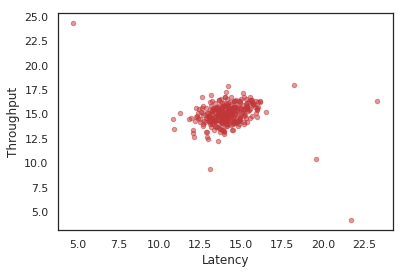

In [10]:
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.5})
plt.show()

## 估计多元高斯参数$\mu$和$\sigma^2$

 <font face=楷体 color=skyblue>
$X_1$和$X_2$并不独立
</font>

In [11]:
mu = X.mean(axis=0)
print(mu, '\n')

cov = np.cov(X.T)
print(cov)

[14.11222578 14.99771051] 

[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


 <font face=楷体 color=skyblue>
例：创建二维网格来计算概率密度
</font>

In [12]:
np.dstack(np.mgrid[0:3,0:3])

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

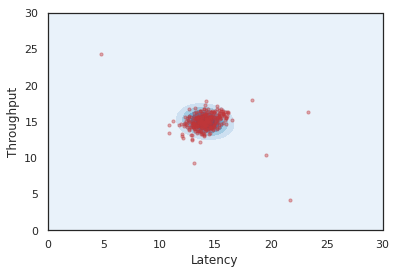

In [13]:
# create multi-var Gaussian model
multi_normal = stats.multivariate_normal(mu, cov)

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})
plt.show()

# 选择阈值 $\epsilon$  
<font face=楷体>
    
* 使用训练集$X$对多元高斯函数建模  
* 使用交叉验证集$(X_{val}, y_{val})$通过找到最佳的“$F-score$”来找到对应的 $\epsilon$  
</font>  

$$\begin{aligned}
&F_1=\frac{2\cdot\ prec\cdot\ rec}{prec+ rec}\\
&prec=\frac{t_p}{t_p+f_p}\\
&rec=\frac{t_p}{t_p+f_n}
\end{aligned}$$

In [0]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]

In [17]:
from sklearn.metrics import f1_score, classification_report

e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 3.593415376575984e-05
Best F-score on validation data: 0.888888888888889



## 使用学习到的 $\epsilon$ 可视化预测 $X_{val}$  
<font face=楷体>

* 使用CV数据找出最好的 $\epsilon$  
* 使用所有数据(培训+验证)创建模型  
* 对测试数据进行预测
</font>

In [0]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


def predict(X, Xval, e, Xtest, ytest):
    """with optimal epsilon, combine X, Xval and predict Xtest
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    """
    Xdata = np.concatenate((X, Xval), axis=0)

    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # calculate probability of test data
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')

    print(classification_report(ytest, y_pred))

    return multi_normal, y_pred

In [18]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       150
           1       1.00      0.50      0.67         4

    accuracy                           0.99       154
   macro avg       0.99      0.75      0.83       154
weighted avg       0.99      0.99      0.98       154



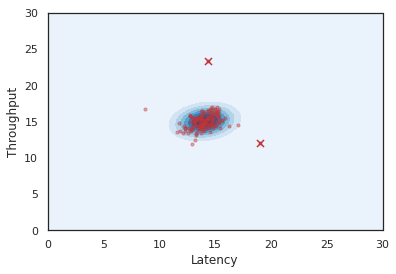

In [19]:
# construct test DataFrame
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create a grid for graphing
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot('Latency', 'Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":10,
                         "alpha":0.4})

# mark the predicted anamoly of CV data. We should have a test set for this...
anamoly_data = data[data['y_pred']==1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=50)
plt.show()

## 高维数据

In [0]:
mat = sio.loadmat('./data/ex8data2.mat')

X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

In [21]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 2.046519143026685e-19
Best F-score on validation data: 0.8


In [22]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        42
           1       0.83      0.62      0.71         8

    accuracy                           0.92        50
   macro avg       0.88      0.80      0.83        50
weighted avg       0.92      0.92      0.92        50



In [23]:
print('find {} anamolies'.format(y_pred.sum()))

find 6 anamolies


<font face=楷体 color=skyblue size=4>
结果与ex8中官方的117 个anamolies的巨大差异是由于：
</font>  

<font face=楷体>
    
* 这里用的是多元高斯函数 
* 对数据的分割非常不同
</font>

# 2-推荐系统  


% Notes: X - num_movies (1682) x num_features (10) matrix of movie features % Theta - num_users (943) x num_features (10) matrix of user features % Y - num_movies x num_users matrix of user ratings of movies % R - num_movies x num_users matrix, where R(i, j) = 1 if the % i-th movie was rated by the j-th user

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"), color_codes=False)
import numpy as np
import pandas as pd
import scipy.io as sio

## 加载数据

In [26]:
movies_mat = sio.loadmat('./data/ex8_movies.mat')
Y, R = movies_mat.get('Y'), movies_mat.get('R')

Y.shape, R.shape

((1682, 943), (1682, 943))

In [0]:
m, u = Y.shape
# m: how many movies
# u: how many users

n = 10  # how many features for a movie

In [28]:
param_mat = sio.loadmat('./data/ex8_movieParams.mat')
theta, X = param_mat.get('Theta'), param_mat.get('X')

theta.shape, X.shape

((943, 10), (1682, 10))

## Cost  

$$J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_m)})=\frac12\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2$$

In [0]:
def serialize(X, theta):
    """serialize 2 matrix
    """
    # X (movie, feature), (1682, 10): movie features
    # theta (user, feature), (943, 10): user preference
    return np.concatenate((X.ravel(), theta.ravel()))


def deserialize(param, n_movie, n_user, n_features):
    """into ndarray of X(1682, 10), theta(943, 10)"""
    return param[:n_movie * n_features].reshape(n_movie, n_features), \
           param[n_movie * n_features:].reshape(n_user, n_features)


# recommendation fn
def cost(param, Y, R, n_features):
    """compute cost for every r(i, j)=1
    Args:
        param: serialized X, theta
        Y (movie, user), (1682, 943): (movie, user) rating
        R (movie, user), (1682, 943): (movie, user) has rating
    """
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movie, n_user = Y.shape
    X, theta = deserialize(param, n_movie, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)

    return np.power(inner, 2).sum() / 2


def gradient(param, Y, R, n_features):
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movies, n_user = Y.shape
    X, theta = deserialize(param, n_movies, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)  # (1682, 943)

    # X_grad (1682, 10)
    X_grad = inner @ theta

    # theta_grad (943, 10)
    theta_grad = inner.T @ X

    # roll them together and return
    return serialize(X_grad, theta_grad)


def regularized_cost(param, Y, R, n_features, l=1):
    reg_term = np.power(param, 2).sum() * (l / 2)

    return cost(param, Y, R, n_features) + reg_term


def regularized_gradient(param, Y, R, n_features, l=1):
    grad = gradient(param, Y, R, n_features)
    reg_term = l * param

    return grad + reg_term

In [30]:
# use subset of data to calculate the cost as in pdf...
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = serialize(X_sub, theta_sub)
cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [31]:
param = serialize(X, theta)  # total real params

cost(serialize(X, theta), Y, R, 10)  # this is real total cost

27918.64012454421

## 梯度  

$$\begin{aligned}
\frac{\partial J}{\partial x_k^{(i)}}=\sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})\theta_k^{(j)}\\
\frac{\partial J}{\partial \theta_k^{(i)}}=\sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(j)}
\end{aligned}$$

In [0]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(gradient(param, Y, R, 10),
                                      n_movie, n_user, 10)


assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

## 正则化代价

In [34]:
# in the ex8_confi.m, lambda = 1.5, and it's using sub data set
regularized_cost(param_sub, Y_sub, R_sub, features, l=1.5)

31.34405624427422

In [35]:
regularized_cost(param, Y, R, 10, l=1)  # total regularized cost

32520.682450229557

## 正则化梯度  


$$\begin{aligned}
\frac{\partial J}{\partial x_k^{(i)}}=\sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})\theta_k^{(j)}+\lambda x_k^{(i)}\\
\frac{\partial J}{\partial \theta_k^{(i)}}=\sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(j)}+\lambda \theta_k^{(j)}
\end{aligned}$$

In [0]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(regularized_gradient(param, Y, R, 10),
                                                                n_movie, n_user, 10)

assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

## 解析movie_id.txt

In [0]:
movie_list = []

with open('./data/movie_ids.txt', encoding='latin-1') as f:
    for line in f:
        tokens = line.strip().split(' ')
        movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)

## 复制评级

In [0]:
ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

## 准备数据

In [39]:
Y, R = movies_mat.get('Y'), movies_mat.get('R')


Y = np.insert(Y, 0, ratings, axis=1)  # now I become user 0
Y.shape

(1682, 944)

In [40]:
R = np.insert(R, 0, ratings != 0, axis=1)
R.shape

(1682, 944)

In [41]:
n_features = 50
n_movie, n_user = Y.shape
l = 10

X = np.random.standard_normal((n_movie, n_features))
theta = np.random.standard_normal((n_user, n_features))

X.shape, theta.shape

((1682, 50), (944, 50))

## 标准化等级

In [43]:
param = serialize(X, theta)
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

## 训练

In [44]:
import scipy.optimize as opt

res = opt.minimize(fun=regularized_cost,
                   x0=param,
                   args=(Y_norm, R, n_features, l),
                   method='TNC',
                   jac=regularized_gradient)

res

     fun: 64721.497815068695
     jac: array([-8.48838632e-06,  7.81312194e-07, -1.08906927e-06, ...,
       -1.45446182e-07, -6.83122272e-07, -1.04873380e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 2412
     nit: 70
  status: 1
 success: True
       x: array([-0.76313181,  0.93866892, -0.34007719, ..., -0.20109122,
        0.25126488,  0.01309171])

In [45]:
X_trained, theta_trained = deserialize(res.x, n_movie, n_user, n_features)
X_trained.shape, theta_trained.shape

((1682, 50), (944, 50))

In [47]:
prediction = X_trained @ theta_trained.T

my_preds = prediction[:, 0] + Y.mean()

idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape

(1682,)

In [48]:
# top ten idx
my_preds[idx][:10]

array([4.12534837, 4.04412879, 3.9932421 , 3.91902597, 3.8169053 ,
       3.81555871, 3.76602318, 3.76322499, 3.75904113, 3.75077919])

In [49]:
for m in movie_list[idx][:10]:
    print(m)

Titanic (1997)
Star Wars (1977)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Raiders of the Lost Ark (1981)
Braveheart (1995)
Return of the Jedi (1983)
Usual Suspects, The (1995)
Godfather, The (1972)
Schindler's List (1993)
